In [1]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import scipy.stats as stats
import sys
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

In [30]:
dataset = pd.read_csv('../../data/full_dataset/imputed_clean_full_dataset.csv.gz', compression = 'gzip')
dataset = dataset.drop(dataset.columns[0], axis = 1)
labels = dataset['labels']
dataset = dataset.drop('labels', axis = 1)
dataset = dataset.apply(pd.to_numeric)
dataset.head()

,chr10:100003785,chr10:100008785,chr10:100010813,chr10:100013244,chr10:100013438,chr10:100013563,chr10:100015474,chr10:100016738,chr10:100016803,chr10:100017453,...,chrX:99840419,chrX:99849017,chrX:99849051,chrX:99890204,chrX:99921757,chrX:99931103,chrX:99933584,chrX:99936147,chrX:99941705,chrX:99956157
0,2,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,2
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,2,0,2,2,0
2,2,0,0,2,0,0,0,0,0,0,...,0,2,2,0,0,0,0,0,2,2
3,0,0,0,0,1,1,0,0,0,0,...,0,2,2,2,0,0,0,2,2,0
4,1,0,0,1,0,0,0,0,0,0,...,0,2,2,0,0,0,0,1,2,0


In [31]:
count = 0
for column in dataset:
    if dataset[column].max() > 2:
        count += 1
        
print(count)

123


In [6]:
normal_data = pd.DataFrame(columns = ['AA', 'AB', 'BB'])

for index, row in dataset.iterrows():
    
    # only counting SNPs
    total_valid = 0
    aa = 0
    ab = 0
    bb = 0
    for variant in row:
        
        if variant == 0:
            aa += 1
            
        elif variant == 1:
            ab += 1
            
        elif variant == 2:
            bb += 1
    
    total_valid = aa + ab + bb
    normal_data.loc[index] = [aa/total_valid, ab/total_valid, bb/total_valid]
    
    sys.stdout.write('\r')
    to_finish = 100 * index/len(dataset.index - 1)
    sys.stdout.write("%.2f" % to_finish + '%')
    #sys.stdout.write('Memory usage:' + str(process.memory_info().rss/1000000) + 'MB')
    sys.stdout.flush()      
        

99.44%

In [9]:
normal_data.head()
normal_data.to_csv('../../data/plots/hwe/frequencies.csv')

In [6]:
k2, p = stats.normaltest(dataset, axis = 0)
print("P-val: " + str(p))

P-val: [9.27320619e-03 5.04941226e-62 8.95151039e-86 ... 2.55262508e-28
 1.55674318e-39 4.72375910e-11]


In [9]:
normal_data = pd.DataFrame(columns = ['chr.pos', '-log10(p-value)'])
variants_name = list(dataset)
count = 0
for index, pvalue in enumerate(p): 
    
    chr_pos = variants_name[index].replace("chr", "")
    if chr_pos.split(':')[0] == 'X':
        chr_pos = '23:' + chr_pos.split(':')[1]
    elif chr_pos.split(':')[0] == 'Y':
        chr_pos = '24:' + chr_pos.split(':')[1]
    
    chr_pos = float(chr_pos.split(':')[0] + '.' + chr_pos.split(':')[1])
    try:
        normal_data.loc[count] = [chr_pos, -math.log10(pvalue)]
    except:
        normal_data.loc[count] = [chr_pos, 0]
    
    sys.stdout.write('\r')
    to_finish = 100 * count/len(p)
    sys.stdout.write("%.2f" % to_finish + '%')
    #sys.stdout.write('Memory usage:' + str(process.memory_info().rss/1000000) + 'MB')
    sys.stdout.flush()
    
    count += 1


normal_data.head()

100.00%

,chr.pos,-log10(p-value)
0,10.100004,2.032770
1,10.100009,61.296759
2,10.100011,85.048104
3,10.100013,2.367291
4,10.100013,4.136797


<IPython.core.display.Javascript object>


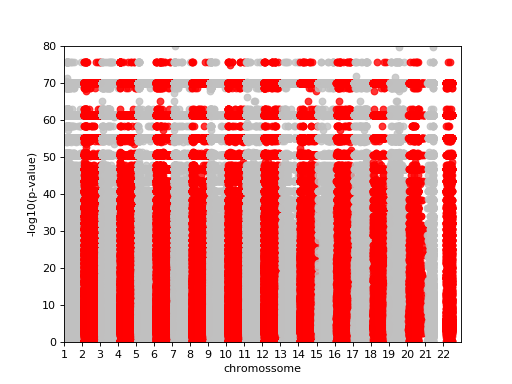

95.65%

In [13]:
# Let the plot, begin

plt.figure()
plt.xlim([1,23])
plt.ylim([0, 80])
for i in range(1,23):
    
    if i%2 == 0:
        indexes = [index for index, pos in enumerate(normal_data['chr.pos']) if int(pos) == i]
        temp_data = normal_data.iloc[indexes]
        sns.regplot(x = temp_data["chr.pos"], y = temp_data["-log10(p-value)"], color = 'red', fit_reg=False)
    else:
        indexes = [index for index, pos in enumerate(normal_data['chr.pos']) if int(pos) == i]
        temp_data = normal_data.iloc[indexes]
        sns.regplot(x = temp_data["chr.pos"], y = temp_data["-log10(p-value)"], color = 'silver', fit_reg=False)

    sys.stdout.write('\r')
    to_finish = 100 * i/23
    sys.stdout.write("%.2f" % to_finish + '%')
    sys.stdout.flush()

plt.xticks(range(1,23))
plt.xlabel('chromossome')
plt.savefig("../../data/plots/chi/normality.png" , dpi = 300, bbox_inches='tight') 

Requires data in this format (https://github.com/khramts/assocplots/blob/master/Tutorial.ipynb):  
  
chr pos       rsID    Chi  
10 9918166 rs4747841 0.5  
10 9918296 rs4749917 0.5  
10 98252982 rs737656 0.67  
10 98253133 rs737657 0.81  

In [3]:
def chisquared(dataset, labels):
    
    normal_dict = {}
    dataset_len = len(list(dataset))
    for index, variant in enumerate(list(dataset)):
        
        # Making contigency table (GTs_no x 2)  
        table = pd.crosstab(dataset[variant], labels)
        table = table.loc[:, [0, 1]]

        chi2, p, dof, ex = stats.chi2_contingency(table, correction = False)
        chisquared_dict[variant] = [chi2, p]

        sys.stdout.write('\r')
        to_finish = 100 * index/dataset_len
        sys.stdout.write("%.2f" % to_finish + '%')
        #sys.stdout.write('Memory usage:' + str(process.memory_info().rss/1000000) + 'MB')
        sys.stdout.flush()

    return(chisquared_dict)


In [ ]:
#to save dict
with open('../../data/tests/LD_and_chisquared/chisquared_recent_data.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in chisquared_dict.items():
        writer.writerow([key, value])

Making following data frame:  
 chr.pos           y  
1.123123    -log10(pval)  
 ...           ...  

In [ ]:

chi_data = pd.DataFrame(columns = ['chr.pos', '-log10(p-value)'])
count = 0
for key, value in chisquared_dict.items():
    
    chr_pos = key.replace("chr", "")
    if chr_pos.split(':')[0] == 'X':
        chr_pos = '23:' + chr_pos.split(':')[1]
    elif chr_pos.split(':')[0] == 'Y':
        chr_pos = '24:' + chr_pos.split(':')[1]
        
    chr_pos = float(chr_pos.split(':')[0] + '.' + chr_pos.split(':')[1])
    chi_data.loc[count] = [chr_pos, -math.log10(value[1])]
    
    sys.stdout.write('\r')
    to_finish = 100 * count/len(chisquared_dict)
    sys.stdout.write("%.2f" % to_finish + '%')
    #sys.stdout.write('Memory usage:' + str(process.memory_info().rss/1000000) + 'MB')
    sys.stdout.flush()
    
    count += 1


chi_data.head()

In [ ]:
print(chr_pos)

In [ ]:
chi_data.to_csv('../../data/tests/LD_and_chisquared/chi_to_plot.csv')

In [11]:
chi_data = pd.read_csv('../../data/tests/LD_and_chisquared/chi_to_plot.csv')
chi_data = chi_data.drop(chi_data.columns[0], axis = 1)
chi_data.head()

,chr.pos,-log10(p-value)
0,10.100004,0.542265
1,10.100009,0.088775
2,10.100011,0.660960
3,10.100013,0.411531
4,10.100013,0.525167


<IPython.core.display.Javascript object>


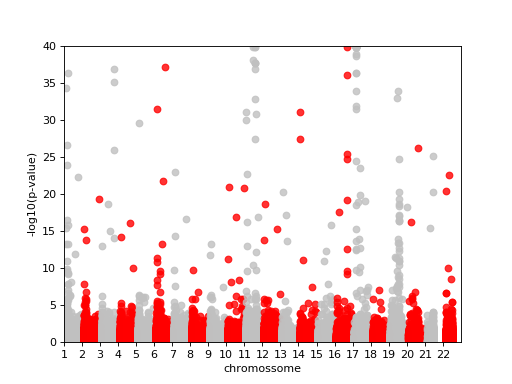

95.65%

In [12]:
# Let the plot, begin

plt.figure()
plt.xlim([1,23])
plt.ylim([0, 40])
for i in range(1,23):
    
    if i%2 == 0 :
        indexes = [index for index, pos in enumerate(chi_data['chr.pos']) if int(pos) == i]
        temp_data = chi_data.iloc[indexes]
        sns.regplot(x = temp_data["chr.pos"], y = temp_data["-log10(p-value)"], color = 'red', fit_reg=False)
    else:
        indexes = [index for index, pos in enumerate(chi_data['chr.pos']) if int(pos) == i]
        temp_data = chi_data.iloc[indexes]
        sns.regplot(x = temp_data["chr.pos"], y = temp_data["-log10(p-value)"], color = 'silver', fit_reg=False)

    sys.stdout.write('\r')
    to_finish = 100 * i/23
    sys.stdout.write("%.2f" % to_finish + '%')
    sys.stdout.flush()

plt.xticks(range(1,23))
plt.xlabel('chromossome')
plt.savefig("../../data/plots/chi/manhattan.png" , dpi = 300, bbox_inches='tight') 

Visualizing Wordcloud of risk genes

<IPython.core.display.Javascript object>


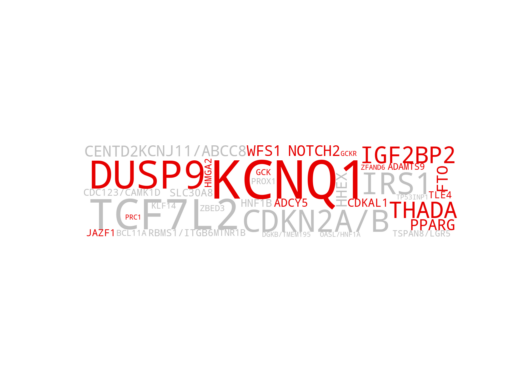

In [10]:
knownvariants = pd.read_csv('../../data/knownvariants/risk_genes.csv', sep = ';')

d = {}
for index, row in knownvariants.iterrows():
    d[row['Locus']] = float(row['OR (95%CI)'].split(' (')[0])
    
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    
    genes_list = ['TLE4', 'IGF2BP2', 'NOTCH2', 'GCK', 'THADA', 'ADCY5', 'PRC1', 'GCKR', 'FTO', 'KCNQ1', 'ADAMTS9', 'HMGA2', \
                 'WFS1', 'DUSP9', 'JAZF1', 'PPARG', 'ZFAND6', 'CDKAL1']
    
    if word in genes_list:
        return("hsl(0,100%,45%)")
    else:
        return("hsl(0,0%,75%)")

wordcloud = WordCloud(width=1200,height=300, max_words=1628,background_color='white',relative_scaling=1,normalize_plurals=False).generate_from_frequencies(d)

plt.imshow(wordcloud.recolor(color_func = grey_color_func),interpolation='bilinear')
plt.axis("off")
plt.savefig("../../data/plots/genes_wordcloud/genes_wordcloud.png", dpi = 300)
plt.tight_layout()
plt.show()


In [53]:
results_dataset = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Classifier', 'Info'])
results_dataset.loc[0] = [0.98, 0.97, 'SVM', 'All Features']
results_dataset.loc[1] = [0.86, 0.80, 'SVM', 'Only Risk Genes']
results_dataset.loc[2] = [0.97, 0.96, 'SVM', 'Top Features']

results_dataset.loc[3] = [0.91, 0.88, 'Extra-Trees', 'All Features']
results_dataset.loc[4] = [0.83, 0.77, 'Extra-Trees', 'Only Risk Genes']
results_dataset.loc[5] = [0.92, 0.89, 'Extra-Trees', 'Top Features']

results_dataset.head() 

,Accuracy,F1-score,Classifier,Info
0,0.98,0.97,SVM,All Features
1,0.86,0.80,SVM,Only Risk Genes
2,0.97,0.96,SVM,Top Features
3,0.91,0.88,Extra-Trees,All Features
4,0.83,0.77,Extra-Trees,Only Risk Genes


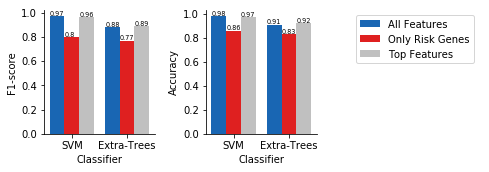

In [60]:
#plt.figure()
total = 6.0
a4_dims = (7, 2.5)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='row', figsize=a4_dims)
flatui = ["#0066cc", "#FF0000", "#C0C0C0"]

plt.tight_layout()

fontP = FontProperties()
fontP.set_size('small')

plt.subplot(1, 3, 1)
sns.despine()
ax = sns.barplot(x = 'Classifier', y = 'F1-score', hue = 'Info', data = results_dataset, palette=sns.color_palette(flatui)
)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize = 6.5)
    
plt.legend().remove()

plt.subplot(1, 3, 2)
sns.despine()

ax = sns.barplot(x = 'Classifier', y = 'Accuracy', hue = 'Info', data = results_dataset, palette=sns.color_palette(flatui)
)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize = 6.5)
    
plt.legend().remove()
plt.tight_layout()

last = plt.subplot(1,3,3)
last.set_frame_on(False)
last.get_xaxis().set_visible(False)
last.get_yaxis().set_visible(False)
empty_data = pd.DataFrame(columns=['Accuracy', 'Classifier', 'Info'])
empty_data.loc[0] = [0,' ','All Features']
empty_data.loc[1] = [0,' ','Only Risk Genes']
empty_data.loc[2] = [0,' ','Top Features']

sns.barplot(x = 'Classifier', y = 'Accuracy', hue = 'Info', data = empty_data, palette=sns.color_palette(flatui))
plt.legend(title = False)

plt.savefig('../../data/plots/classifiers_results/class_results2.png', dpi = 300)

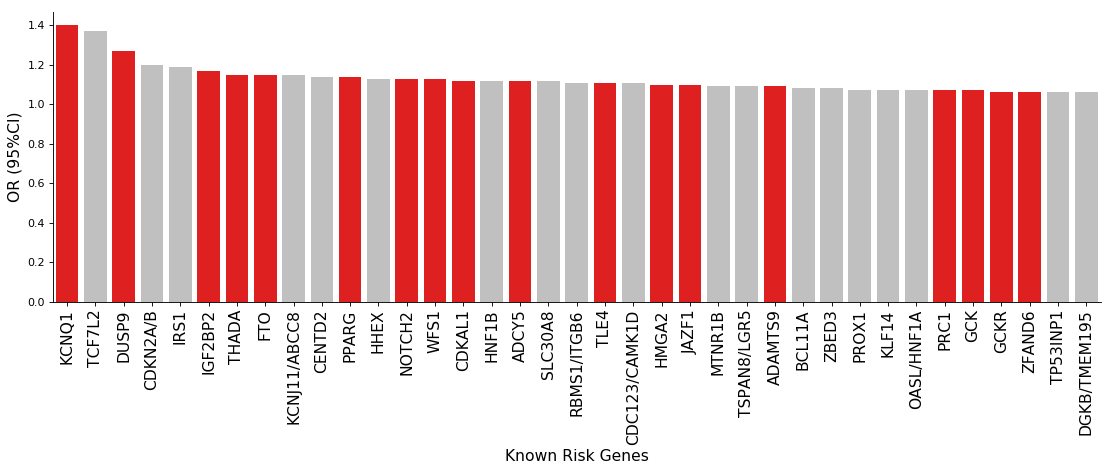

In [94]:
knownvariants = pd.read_csv('../../data/knownvariants/risk_genes.csv', sep = ';')
genes_list = ['TLE4', 'IGF2BP2', 'NOTCH2', 'GCK', 'THADA', 'ADCY5', 'PRC1', 'GCKR', 'FTO', 'KCNQ1', 'ADAMTS9', 'HMGA2', \
             'WFS1', 'DUSP9', 'JAZF1', 'PPARG', 'ZFAND6', 'CDKAL1']

known_list = []
for index, row in knownvariants.iterrows():
    knownvariants.loc[index, 'OR (95%CI)'] = float(row['OR (95%CI)'].split(' (')[0])
    
    if row['Locus'] in genes_list:
        known_list.append('Present in the Dataset')
    else:
        known_list.append('Not-Present in the Dataset')    

knownvariants['Presence'] = known_list
knownvariants = knownvariants.sort_values('OR (95%CI)', axis = 0, ascending = False)

plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
flatui = {"Not-Present in the Dataset":"#C0C0C0", "Present in the Dataset":"#FF0000"}

ax = sns.barplot(x = 'Locus', y = 'OR (95%CI)', data = knownvariants, order = knownvariants['Locus'], palette = knownvariants['Presence'].map(flatui)) 
lg = ax.get_legend
plt.xticks(size = 14)
plt.xlabel('Known Risk Genes',fontsize=14)
plt.ylabel('OR (95%CI)', fontsize=14)
handles, labels = ax.get_legend_handles_labels()
#plt.legend()
sns.despine()

plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('../../data/plots/genes_wordcloud/presence.png')

In [3]:
roc_dataset = pd.DataFrame(columns=['Situation', 'AUC'])
roc_dataset.loc[0] = ['a', 0.99]
roc_dataset.loc[1] = ['b', 0.94]
roc_dataset.loc[2] = ['c', 0.99]

roc_dataset.loc[3] = ['d', 0.93]
roc_dataset.loc[4] = ['e', 0.90]
roc_dataset.loc[5] = ['f', 0.97]

roc_dataset.head() 

,Situation,AUC
0,a,0.99
1,b,0.94
2,c,0.99
3,d,0.93
4,e,0.90


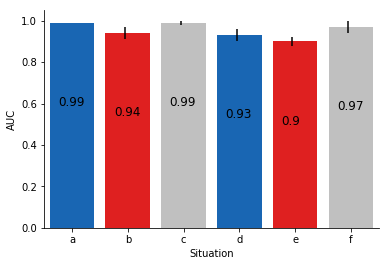

In [61]:
flatui = ["#0066cc", "#FF0000", "#C0C0C0"]
plt.figure()
ax = sns.barplot(x = 'Situation', y = 'AUC', data = roc_dataset, palette=sns.color_palette(flatui)
)

ci = [0.00, 0.03, 0.01, 0.03, 0.02, 0.03]
sns.despine()
count = 0
for p in ax.patches:
    plt.errorbar(p.get_x()+0.35, p.get_height(), yerr=ci[count], ecolor = 'black')
    ax.annotate(str(p.get_height()), (p.get_x() +0.15, p.get_height() -0.4), fontsize = 12)
    count += 1

plt.savefig('../../data/plots/roc/aucs.png')